In [633]:
"""Lennard-Jones for specific atom"""

import numpy as np

class atom_props():
    def __init__(self, sigma, epsilon):
        self.sig = sigma
        self.eps = epsilon

def pot_LJ(atom,r):
    sig = atom.sig
    eps = atom.eps
    return 4*eps*((sig/r)**12 - (sig/r)**6)   

def pot_LJ_dl(r):
    u = np.zeros(r.shape)
    u[r != 0] = 4*((1/r[r != 0])**12 - (1/r[r != 0])**6)   
    u[r == 0] = 0 
    return u

def grad_pot_LJ_dl(r):
    u = np.zeros(r.shape)
    u[r != 0] = -24*(2*(1/r[r != 0])**13 - (1/r[r != 0])**7)   
    u[r == 0] = 0 
    return u

# Initiazlize box and particles
def particle_generator(L, N, dim):
    x_init = np.random.random((dim,N))*L
    v_init = np.zeros((dim,N),dtype=float)
    return x_init, v_init

def particle_dist(L, N, x, dim):
    # Particles NN, differences, coordinates

    # Calcolate distances to NN
    r = np.zeros((N,N),dtype=float)
    NN_max_dist = L/2
    # xv = np.zeros((dim,N,N),dtype=float)
    delta_tot = np.zeros((dim,N,N))
    
    for i in range(dim):
        # Difference between coordinates per dimension
        delta = x[i,:]-np.transpose([x[i,:]])
        '''
        # look for NN, define 'virtual' points
        xv[i,:,:] =  np.tile(x[i,:].reshape(N,1),N)
        xv[i][delta > NN_max_dist] = L + xv[i][delta > NN_max_dist] 
        xv[i][delta < -NN_max_dist] = -L + xv[i][delta < -NN_max_dist] 
        '''
        # New difference including 'virtu=al' coordinates
        delta[delta > NN_max_dist] = -(L-delta[delta > NN_max_dist])
        delta[delta < -NN_max_dist] = L + delta[delta < -NN_max_dist]
       
        
        delta_tot[i] = delta
        r += delta**2   
        r = np.sqrt(r) 
        
    return delta_tot, r

def pot_and_force(delta_tot, r, dim, N):
    # Potentials and Forces
    F = np.zeros((dim,N,N),dtype=float)
    U = pot_LJ_dl(r).sum(axis=1)
    
    for i in range(dim):
        F[i][r != 0] = -grad_pot_LJ_dl(r[r != 0])*delta_tot[i][r != 0]/(r[r != 0])
    r[r == 0] = np.inf
    F_sum = F.sum(axis=1)
   
    return F_sum, U

In [485]:
# Plotting the potential for Argon
import matplotlib.pyplot as plt
k_b = 1.38e-23
argon = atom_props(3.405e-10, k_b*119.8)        

x_t = np.linspace(0.9,5,1000)
u_t = pot_LJ_dl(x_t);

plt.plot(x_t,u_t)
plt.xlabel(r'Distance r/$\sigma$')
plt.ylabel(r'Energy u/$\epsilon$')


   

In [638]:

# Initial positions
L = 10 # Box size
N = 3 # partciles
dim = 2 # Dimensions of the probem

x_init, v_init = particle_generator(L, N, dim) 


In [ ]:
import copy as cp

delta_t = 1e-3
t_range = np.arange(0, 10000*delta_t, delta_t)
E_kin = np.zeros((len(t_range),1), dtype=float)
E_pot = np.zeros((len(t_range),1), dtype=float)

x = cp.deepcopy(x_init)
v = cp.deepcopy(v_init)

for i, t in enumerate(t_range):
    delta_tot, r = particle_dist(L, N, x, dim)
    F_tot, U_tot = pot_and_force(delta_tot, r, dim, N)
    # step_size = np.sum((abs((v * delta_t)) > 0.0005))
    x += v * delta_t
    v += F_tot * delta_t
    x[x > L] = (x[x > L]%L)
    x[x < 0] = abs((x[x < 0]%L))
    
    # Fix energy conservation with direction of the kinetic energy
    E_kin[i] = 0.5*(v**2).sum(axis=1).sum(axis=0)
    E_pot[i] = U_tot.sum(axis=0)
    
    
    plt.plot(x[0,0],x[1,0],'go')
    plt.plot(x[0,1],x[1,1],'yo')
    plt.plot(x[0,2],x[1,2],'bo')
       
    for i in range(N):
        plt.plot([x[0,i],x[0,i]+F_tot[0,i]/sum(sum(abs(F_tot)))],[x[1,i],x[1,i]+F_tot[1,i]/sum(sum(abs(F_tot)))])
    
    


In [ ]:
plt.plot(0,0)
plt.plot(L,L)
plt.axis('square')            
plt.show()

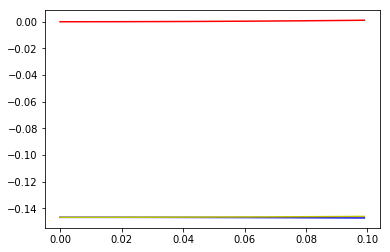

In [637]:
plt.plot(t_range,E_pot,'b')
plt.plot(t_range,E_kin,'r')
plt.plot(t_range,E_kin+E_pot,'y')
plt.show()

array([[  5.19235779e+00,  -8.94900618e+01,  -2.54560318e+01,
          5.81642368e+00,  -9.04617546e+00,   3.08861601e+01,
          5.05733840e+00,  -2.16602910e+01,  -4.97595247e+00,
         -2.11983867e+00,  -2.70931175e+01,   5.80946936e+01,
         -1.21449202e+01,  -1.53519897e+01,   4.00347384e+00,
          2.41468943e+02,  -2.87249230e+01,  -1.75355833e+01,
          2.05700954e+00,   6.67383590e+00,   1.26734760e+00,
          1.43619234e+01,  -2.02849567e+01,  -6.16379417e+01,
         -9.04020737e+00,  -2.20542214e+02,  -1.37269123e+00,
          1.17904910e+02,   7.17089900e+00,  -1.63916706e+01],
       [  7.99034999e-01,  -1.23917270e+02,   3.18951242e+02,
          6.30625104e+01,  -1.20778386e+01,  -2.08137016e-01,
          4.44875360e+00,  -2.08338790e+01,  -4.33721453e+01,
          1.71529459e+01,  -7.99301602e+00,  -2.51713962e+01,
         -6.05041050e+00,   3.71250470e-01,  -7.18092166e+00,
          2.27500882e+02,   7.07613526e+01,   2.94794228e+00,
       

In [632]:
(-4)%3

2